In [6]:
import sys
sys.path.append('../../src')

In [7]:
import pandas as pd
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource, Scope
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min
from scipy import stats

In [ ]:
# To solve the scheduling level problem for the motivating example of 3 forms of LNG production with varying GWP (resets every year), varying ERCOT power prices & NG prices (fluctuates every hour for the next 5 years)
# For optimal cost vs emission scenario (and varying weights for emission reduction , eg, for 10% reduction in emission, what is the best case scenario)

In [8]:
horizon = 1
scales = TemporalScale(discretization_list=[5, 365, 1])

In [9]:
bigM = 10**8
smallM = 0.001

In [10]:
import pandas as pd

# Read the Excel file into a DataFrame
elec_price_df = pd.read_excel(r"C:\Users\marcopdsousa\Documents\energiapy\AICHE\AICHE 2025 Data\Complete_ERCOT_Prices - 5 year_Daily.xlsx")

# Increment index by 1 (optional, depending on what you want to do)
elec_price_df.index = elec_price_df.index + 1

# Display DataFrame
print(elec_price_df)

# Get the maximum price from the first column
elec_price = elec_price_df.max()[0]
print("Max electricity price:", elec_price)

      Settlement Point Price
1                      14.70
2                      18.45
3                      17.73
4                      13.60
5                      16.14
...                      ...
1821                   17.11
1822                   22.73
1823                   12.23
1824                   16.13
1825                   20.11

[1825 rows x 1 columns]
Max electricity price: 196.15


C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_27312\1491761965.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]


In [145]:
# Formula verified

#for index in elec_price_df.index:
    #if index <= 20:
        #GWP_value = 112.23
    #elif index <= 70:
        #GWP_value = 99.99
    #elif index <= 72:
        #GWP_value = 92.84
    #else:
        #GWP_value = 83.82
    
    #print(f"Index: {index}, GWP_value: {GWP_value}")  # To check the values dynamically


In [11]:
for index in elec_price_df.index:
    if index <= 365:
        GWP_value = 112.23
    elif index >365 and index<= 730:
        GWP_value = 99.99
    elif index >730 and index<= 1095:
        GWP_value = 92.84
    elif index >1095 and index<= 1460:
        GWP_value = 87.76
    else:
        GWP_value= 83.82
        # for 5 years

In [147]:
# Natural gas great alternative to Coal

In [12]:
# Outputs

CO2 = Resource(name='CO2 Vented from the process', basis='kg/hr',
               label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True, scope = Scope.ONE)

Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               label='Methane from the process', block='Resource', gwp = GWP_value, sell=True, scope = Scope.ONE)

NGL = Resource(name='Natural Gas Liquids_in_extraction', basis='kg/hr', label='Natural Gas Liquids_in_extraction', block='Resource', sell=True)

ProducedWater = Resource(name='H2O vented from the process',
               basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')

LNG = Resource(name='LNG', demand = True, basis='kg/hr', label='LNG', block='Resource')

Boil_off_LNG = Resource(name='Boil_off_LNG', sell=True, basis='kg/hr', label='Boil_off_LNG', block='Resource')

Heat_Energy = Resource(name='Heat_Energy', basis='MW', label='Heat_Energy', sell=True, block='Resource')

#Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               #label='Methane from the process', block='Resource', gwp = GWP_value, varying = [VaryingResource.DETERMINISTIC_GWP], sell=True, scope = Scope.ONE)

# Inputs

Power = Resource(name='Power', basis='MW', label='Power generated')

GridPower = Resource(name='GridPower', basis='MW',
                     cons_max=bigM, label='Power bought', gwp= 339.6322, price =elec_price ,varying = [VaryingResource.DETERMINISTIC_PRICE], scope = Scope.TWO)
# Grid Power GWP from average value of time-varying GWP

ResourceWater = Resource(name='H2O',
               basis='kg/hr', cons_max=bigM, label='Water', price = 0.002, block='Resource')

Proppant_Additive = Resource(name='Proppant_Additive', basis='kg/hr', label='Proppant_Additive', block='Resource', price= 0.975, cons_max=bigM)
# Reference Link: https://www.maximizemarketresearch.com/market-report/global-proppant-market/14899/?utm_source=chatgpt.com

Diesel = Resource(name='Diesel', basis='kg/hr', label='Diesel', block='Resource', price= 0.98, cons_max=bigM)
# Reference Link: https://businessanalytiq.com/procurementanalytics/index/diesel-price-index/

Cooling_Water_In_Liquifaction = Resource(name='Cooling_Water_In_Liquifaction', basis='kg/hr', label='Cooling_Water_In_Liquifaction', block='Resource', cons_max=bigM, price= 0.0572)
# Reference link: https://www.intratec.us/products/industry-economics-worldwide/utility/cooling-water-united-states

LNG =  Resource(name='LNG', demand=True, basis='kg/hr', label='LNG', block='Resource')

Glycol = Resource(name='Glycol', basis='kg/hr', label='Glycol', block='Resource', cons_max=bigM, price= 0.052)
# Reference link: https://businessanalytiq.com/procurementanalytics/index/ethylene-glycol-price-index/

MDEA = Resource(name='MDEA', basis='kg/hr', label='MDEA', block='Resource', cons_max=bigM, price= 10)

In [13]:
print(elec_price_df.shape[0])

1825


In [14]:
# FU: 1 kg/hr of LNG
# 3 methane producing processes

Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='Grid', basis='MW')

Conventional_NG = Process(name='Conventional_NG', conversion={Boil_off_LNG: 0.01, Power: -0.00015, ResourceWater: -0.5, Diesel: -0.000741382, Glycol: -0.000818111, MDEA: -0.012391658, Cooling_Water_In_Liquifaction: -19.85645933,
                                                              Methane: 0.025, CO2: 0.179504505, NGL: 0.3, Heat_Energy: 0.02, ProducedWater: 0.912, LNG: 1}, fopex=0.0325, vopex=0.0325, prod_min=0.1, prod_max=bigM, label='Conventional LNG', basis='kg/hr')  

# https://shareholdersunite.com/the-ioc-files-useful-background-material/the-economics-of-lng/

ShaleGas = Process(name='ShaleGas', conversion={Boil_off_LNG: 0.01, Power: -0.0003, ResourceWater: -2, Diesel: -0.002041766, Glycol: -0.01875, MDEA: -0.284, Cooling_Water_In_Liquifaction: -19.85645933,
                                                              Methane: 0.0395, CO2: 4.114, NGL: 0.0557, Heat_Energy: 0.074, ProducedWater: 0.00002205, LNG: 1}, fopex=2.24, vopex=1.17, prod_min=0.1, prod_max=bigM, label='ShaleGas', basis='kg/hr')
# https://marcelluscoalition.org/wp-content/uploads/2012/07/The-Arithmetic-of-Shale-Gas.pdf

Coalbed = Process(name='Coalbed', conversion={Boil_off_LNG: 0.01, Power: -0.001, Diesel: -0.075, Glycol: -0.026539527, MDEA: -0.401985372, Cooling_Water_In_Liquifaction: -19.85645933,
                                                              Methane: 0.811, CO2: 5.823126126, NGL: 0.062761905, Heat_Energy: 0.002, ProducedWater: 6.2755, LNG: 1}, fopex=0.245, vopex=0.415, prod_min=0.1, prod_max=bigM, label='CoalBed', basis='kg/hr')

# capacity needed? No

In [15]:
process_set = {Grid, Conventional_NG, ShaleGas, Coalbed}

In [16]:
# network scale level is 2, due to indexing issues. However, this shouldn't change the final output as capex is smallM. Fopex will be mentiond in hourly level

houston = Location(name='Houston', processes=process_set,  price_factor={GridPower: elec_price_df}, gwp_factor={Methane:GWP_value},
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=1, price_scale_level=2, gwp_scale_level = 2)



c:\Users\marcopdsousa\Documents\energiapy\AICHE\AICHE 2025\../../src\energiapy\components\location.py:147: UserWarning: Input should be a dict of a DataFrame, Dict[Resource, float]
  warn(


In [17]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=1, network_scale_level=0,
                    purchase_scale_level = 2, scheduling_scale_level=2, capacity_scale_level=2, gwp_scale_level = 2, 
                    label='full_case', demand={houston: {LNG:2000}})

In [154]:
print("Contents of scenario.gwp_dict:", Location.gwp_factor)
#code not reading demand or gwp factor

Contents of scenario.gwp_dict: None


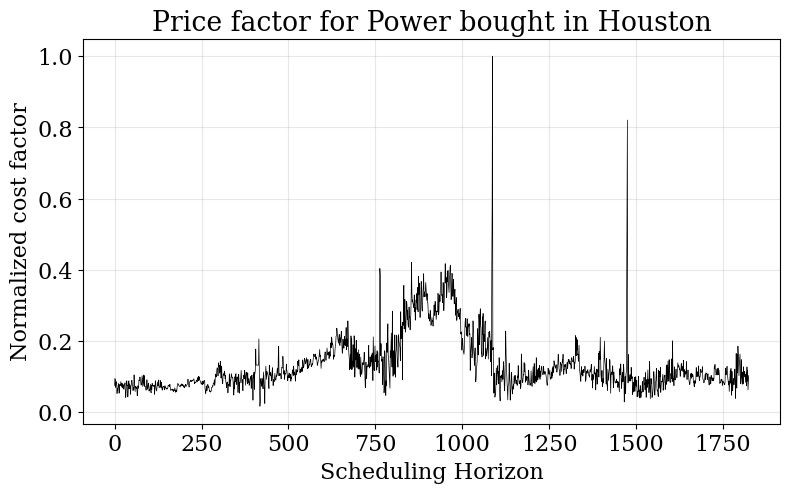

In [18]:
plot_scenario.price_factor(scenario=scenario, location=houston, resource=GridPower, fig_size=(9, 5), color='black')

In [19]:
#, Constraints.MODE

milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.NETWORK,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint storage capex
constraint process incidental
constraint location capex
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [157]:
print("Type of scenario.price_dict:", type(scenario.price_dict))
print("Contents of scenario.price_dict:", scenario.price_dict)

Type of scenario.price_dict: <class 'dict'>
Contents of scenario.price_dict: {'Houston': {'MDEA': 10, 'Glycol': 0.052, 'Diesel': 0.98, 'Natural Gas Liquids_in_extraction': 0, 'Cooling_Water_In_Liquifaction': 0.0572, 'Power': 0, 'CO2 Vented from the process': 0, 'Boil_off_LNG': 0, 'H2O vented from the process': 0, 'Heat_Energy': 0, 'Methane leaked from the process': 0, 'LNG': 0, 'GridPower': np.float64(8474.69), 'H2O': 0.002}}


In [158]:
type(milp_cost)

pyomo.core.base.PyomoModel.ConcreteModel

In [20]:
print("Scale 1 Indices:", list(scales.scale_iter(1)))
print("Scale 2 Indices:", list(scales.scale_iter(2)))

Scale 1 Indices: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0, 100), (0, 101), (0, 102), (0, 103), (0, 104), (0, 105), (0, 106), (0, 107), (0, 108), (0

In [21]:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons1.add(expr = milp_cost.P['Houston', 'Conventional_NG', *i] - milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons2.add(milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])


In [22]:
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons3.add(expr = milp_cost.P['Houston', 'ShaleGas', *i] - milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons4.add(milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'ShaleGas', *i] <= 0.05*milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])


In [23]:
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons5.add(expr = milp_cost.P['Houston', 'Coalbed', *i] - milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_cost.cons6.add(milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'Coalbed', *i] <= 0.05*milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])


In [24]:
results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 122699 rows, 604636 columns and 429608 nonzeros
Model fingerprint: 0xe7751856
Variable types: 604616 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 100765 rows and 597296 columns
Presolve time: 0.06s
Presolved: 21934 rows, 7340 columns, 49343 nonzeros
Variable types: 7320 continuous, 20 integer (20 binary)
Performing another presolve...
Presolve removed 3

In [25]:
results_cost.output['objective']

4737511.0277991975

In [26]:
4748525.212799198

4748525.212799198

In [27]:
results_cost.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.0,
 ('Houston', 'Coalbed', 1): 0.0,
 ('Houston', 'Coalbed', 2): 0.0,
 ('Houston', 'Coalbed', 3): 0.0,
 ('Houston', 'Coalbed', 4): 0.0,
 ('Houston', 'Conventional_NG', 0): 2000.0,
 ('Houston', 'Conventional_NG', 1): 2000.0,
 ('Houston', 'Conventional_NG', 2): 2000.0,
 ('Houston', 'Conventional_NG', 3): 2000.0,
 ('Houston', 'Conventional_NG', 4): 2000.0,
 ('Houston', 'Grid', 0): 2.9,
 ('Houston', 'Grid', 1): 2.9,
 ('Houston', 'Grid', 2): 2.9,
 ('Houston', 'Grid', 3): 2.9,
 ('Houston', 'Grid', 4): 2.9,
 ('Houston', 'ShaleGas', 0): 0.0,
 ('Houston', 'ShaleGas', 1): 0.0,
 ('Houston', 'ShaleGas', 2): 0.0,
 ('Houston', 'ShaleGas', 3): 0.0,
 ('Houston', 'ShaleGas', 4): 0.0}

In [28]:
results_cost.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 0.0,
 ('Houston', 'Coalbed', 0, 1, 0): 0.0,
 ('Houston', 'Coalbed', 0, 2, 0): 0.0,
 ('Houston', 'Coalbed', 0, 3, 0): 0.0,
 ('Houston', 'Coalbed', 0, 4, 0): 0.0,
 ('Houston', 'Coalbed', 0, 5, 0): 0.0,
 ('Houston', 'Coalbed', 0, 6, 0): 0.0,
 ('Houston', 'Coalbed', 0, 7, 0): 0.0,
 ('Houston', 'Coalbed', 0, 8, 0): 0.0,
 ('Houston', 'Coalbed', 0, 9, 0): 0.0,
 ('Houston', 'Coalbed', 0, 10, 0): 0.0,
 ('Houston', 'Coalbed', 0, 11, 0): 0.0,
 ('Houston', 'Coalbed', 0, 12, 0): 0.0,
 ('Houston', 'Coalbed', 0, 13, 0): 0.0,
 ('Houston', 'Coalbed', 0, 14, 0): 0.0,
 ('Houston', 'Coalbed', 0, 15, 0): 0.0,
 ('Houston', 'Coalbed', 0, 16, 0): 0.0,
 ('Houston', 'Coalbed', 0, 17, 0): 0.0,
 ('Houston', 'Coalbed', 0, 18, 0): 0.0,
 ('Houston', 'Coalbed', 0, 19, 0): 0.0,
 ('Houston', 'Coalbed', 0, 20, 0): 0.0,
 ('Houston', 'Coalbed', 0, 21, 0): 0.0,
 ('Houston', 'Coalbed', 0, 22, 0): 0.0,
 ('Houston', 'Coalbed', 0, 23, 0): 0.0,
 ('Houston', 'Coalbed', 0, 24, 0): 0.0,
 ('Houston

In [29]:
results_cost.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 1, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 2, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 3, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 4, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 5, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 6, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 7, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 8, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 9, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 10, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 11, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 12, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 13, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 14, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 15, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 16, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 17, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 18, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 19, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 20, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 21, 0): 0.0,
 ('Houston', 'Boil_o

In [206]:
results_cost.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 1, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 2, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 3, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 4, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 5, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 6, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 7, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 8, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 9, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 10, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 11, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 12, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 13, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 14, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 15, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 16, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 17, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 18, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 19, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 20, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 21, 0): 0.0,
 ('Houston', 'Boil_o

In [183]:
data1 = results_cost.output['P']
df1 = pd.DataFrame(data1,index=[0])
df1 = df1.T
# Export the DataFrame to an Excel file
df1.to_excel('C:\\Users\\saatvisuresh_1\\Desktop\\Saatvi Thesis\\MinCost_Production Data.xlsx', index=True)

In [184]:
data2 = results_cost.output['global_warming_potential_resource']
df2 = pd.DataFrame(data2,index=[0])
df2 = df2.T
# Export the DataFrame to an Excel file
df2.to_excel('C:\\Users\\saatvisuresh_1\\Desktop\\Saatvi Thesis\\MinCost_GWP Data.xlsx', index=True)

In [185]:
#, Constraints.MODE

milp_gwp = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.MIN_GWP, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
constraint network cost
objective gwp min


In [186]:
print("Scale 1 Indices:", list(scales.scale_iter(1)))
print("Scale 2 Indices:", list(scales.scale_iter(2)))

Scale 1 Indices: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0, 100), (0, 101), (0, 102), (0, 103), (0, 104), (0, 105), (0, 106), (0, 107), (0, 108), (0

In [187]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons1.add(expr = milp_gwp.P['Houston', 'Conventional_NG', *i] - milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons2.add(milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons3.add(expr = milp_gwp.P['Houston', 'ShaleGas', *i] - milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons4.add(milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons5.add(expr = milp_gwp.P['Houston', 'Coalbed', *i] - milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons6.add(milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])



In [189]:
results_gwp = solve(scenario=scenario, instance=milp_gwp,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 122680 rows, 604616 columns and 429599 nonzeros
Model fingerprint: 0xdc002b15
Coefficient statistics:
  Matrix range     [2e-05, 8e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+08]
Presolve removed 109913 rows and 599143 columns
Presolve time: 0.23s
Presolved: 12767 rows, 5473 columns, 34653 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.299e+04
 Factor NZ  : 1.723e+05 (roughly 9 MB of memory)
 Factor Ops : 2.532e+06 (less than 1 second per iteration)


In [202]:
results_gwp.output['global_warming_potential_location']

{('Houston', 0): 8489715.072750058,
 ('Houston', 1): 8489715.072750058,
 ('Houston', 2): 8489715.072750058,
 ('Houston', 3): 8489715.072750058,
 ('Houston', 4): 8489715.072750058}

In [200]:
results_cost.output['P_network']

{('Coalbed', 0): 0.0,
 ('Coalbed', 1): 0.0,
 ('Coalbed', 2): 0.0,
 ('Coalbed', 3): 0.0,
 ('Coalbed', 4): 0.0,
 ('Conventional_NG', 0): 730000.0,
 ('Conventional_NG', 1): 730000.0,
 ('Conventional_NG', 2): 730000.0,
 ('Conventional_NG', 3): 730000.0,
 ('Conventional_NG', 4): 730000.0,
 ('Grid', 0): 109.5,
 ('Grid', 1): 109.5,
 ('Grid', 2): 109.5,
 ('Grid', 3): 109.5,
 ('Grid', 4): 109.5,
 ('ShaleGas', 0): 0.0,
 ('ShaleGas', 1): 0.0,
 ('ShaleGas', 2): 0.0,
 ('ShaleGas', 3): 0.0,
 ('ShaleGas', 4): 0.0}

In [199]:
results_gwp.output['P_network']

{('Coalbed', 0): 0.0,
 ('Coalbed', 1): 0.0,
 ('Coalbed', 2): 0.0,
 ('Coalbed', 3): 0.0,
 ('Coalbed', 4): 0.0,
 ('Conventional_NG', 0): 730000.0,
 ('Conventional_NG', 1): 730000.0,
 ('Conventional_NG', 2): 730000.0,
 ('Conventional_NG', 3): 730000.0,
 ('Conventional_NG', 4): 730000.0,
 ('Grid', 0): 109.49999999999932,
 ('Grid', 1): 109.49999999999932,
 ('Grid', 2): 109.49999999999932,
 ('Grid', 3): 109.49999999999932,
 ('Grid', 4): 109.49999999999932,
 ('ShaleGas', 0): 0.0,
 ('ShaleGas', 1): 0.0,
 ('ShaleGas', 2): 0.0,
 ('ShaleGas', 3): 0.0,
 ('ShaleGas', 4): 0.0}

In [192]:
results_gwp.output['Cost']

{None: 1263498200.2128}

In [193]:
data = results_gwp.output['P']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel('C:\\Users\Saatvi Suresh\\Desktop\\Project\\3 Day Project Results\\GWP_Min_3Day.xlsx', index=True)

OSError: Cannot save file into a non-existent directory: 'C:\Users\Saatvi Suresh\Desktop\Project\3 Day Project Results'

Emission Restrictions by 10%

In [196]:
results_cost.output['global_warming_potential_network'][0]

8489715.07275

In [138]:
milp_gwp_10 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from src.energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_10, gwp_reduction_pct = 10, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons1.add(expr = milp_gwp_10.P['Houston', 'Conventional_NG', *i] - milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons2.add(milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons3.add(expr = milp_gwp_10.P['Houston', 'ShaleGas', *i] - milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons4.add(milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons5.add(expr = milp_gwp_10.P['Houston', 'Coalbed', *i] - milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons6.add(milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_10 = solve(scenario=scenario, instance=milp_gwp_10,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x7ba6adba
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.02s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 1.907693e+05, 218 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_10.output['objective']

190769.25400029315

In [ ]:
results_gwp_10.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_10.output['global_warming_potential_location']

{('Houston', 0): 1369730.10608689}

In [ ]:
results_gwp_10.output['B_location']
#What is B,C location?

{('Houston', 'Chemicals_in_Processing', 0): 24723.438252016338,
 ('Houston', 'Chemicals_in_extraction', 0): 1441.0322252775352,
 ('Houston', 'GridPower', 0): 158450.72861260158,
 ('Houston', 'H2O', 0): 24.99903754022148,
 ('Houston', 'ProppantSand_in_extraction', 0): 0.0}

In [ ]:
# Not sure why
results_gwp_10.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 1): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 2): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 3): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 4): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 5): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 6): 42.806417372833586,
 ('Houston', 'Coalbed', 0, 0, 7): 40.87019202561984,
 ('Houston', 'Coalbed', 0, 0, 8): 42.91370162690084,
 ('Houston', 'Coalbed', 0, 0, 9): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 10): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 11): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 12): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 13): 45.05938670824588,
 ('Houston', 'Coalbed', 0, 0, 14): 45.05938670824589,
 ('Houston', 'Coalbed', 0, 0, 15): 42.80641737283359,
 ('Houston', 'Coalbed', 0, 0, 16): 40.66609650419191,
 ('Houston', 'Coalbed', 0, 0, 17): 38.632791678982315,
 ('Houston', 'Coalbed', 0, 0, 18): 3

20% Emission Restrictions

In [ ]:
milp_gwp_20 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_20, gwp_reduction_pct = 20, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons1.add(expr = milp_gwp_20.P['Houston', 'Conventional_NG', *i] - milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons2.add(milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons3.add(expr = milp_gwp_20.P['Houston', 'ShaleGas', *i] - milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons4.add(milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons5.add(expr = milp_gwp_20.P['Houston', 'Coalbed', *i] - milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons6.add(milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])



In [ ]:
results_gwp_20 = solve(scenario=scenario, instance=milp_gwp_20,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x6e80c066
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.02s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 3.510818e+05, 215 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_20.output['objective']

351081.77254176745

In [ ]:
results_gwp_20.output['Vopex_location']

{('Houston', 0): 7527.342328615063}

In [ ]:
results_gwp_20.output['global_warming_potential_location']

{('Houston', 0): 1217537.8720772357}

In [ ]:
results_gwp_20.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_20.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 1): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 2): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 3): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 4): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 5): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 6): 35.39907732243319,
 ('Houston', 'Coalbed', 0, 0, 7): 33.79790172806606,
 ('Houston', 'Coalbed', 0, 0, 8): 35.48779681446936,
 ('Houston', 'Coalbed', 0, 0, 9): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 10): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 11): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 12): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 13): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 14): 37.262186655192835,
 ('Houston', 'Coalbed', 0, 0, 15): 35.39907732243319,
 ('Houston', 'Coalbed', 0, 0, 16): 33.62912345631153,
 ('Houston', 'Coalbed', 0, 0, 17): 31.947667283495953,
 ('Houston', 'Coalbed', 0

30% emission restrictions

In [ ]:
milp_gwp_30 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_30, gwp_reduction_pct = 30, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons1.add(expr = milp_gwp_30.P['Houston', 'Conventional_NG', *i] - milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons2.add(milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons3.add(expr = milp_gwp_30.P['Houston', 'ShaleGas', *i] - milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons4.add(milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons5.add(expr = milp_gwp_30.P['Houston', 'Coalbed', *i] - milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons6.add(milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_30 = solve(scenario=scenario, instance=milp_gwp_30,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x7cb9cc3c
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.00s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 5.113943e+05, 217 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_30.output['objective']

511394.291083242

In [ ]:
results_gwp_30.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 1): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 2): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 3): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 4): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 5): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 6): 27.991737272032776,
 ('Houston', 'Coalbed', 0, 0, 7): 26.725611430512256,
 ('Houston', 'Coalbed', 0, 0, 8): 28.06189200203787,
 ('Houston', 'Coalbed', 0, 0, 9): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 10): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 11): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 12): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 13): 29.464986602139764,
 ('Houston', 'Coalbed', 0, 0, 14): 29.46498660213976,
 ('Houston', 'Coalbed', 0, 0, 15): 27.991737272032772,
 ('Houston', 'Coalbed', 0, 0, 16): 26.59215040843113,
 ('Houston', 'Coalbed', 0, 0, 17): 25.262542888009573,
 ('Houston', 'Coalbed',

In [ ]:
results_gwp_30.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_30.output['global_warming_potential_location']

{('Houston', 0): 1065345.638067581}

40% Emission reduction

In [ ]:
milp_gwp_40 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_40, gwp_reduction_pct = 40, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons1.add(expr = milp_gwp_40.P['Houston', 'Conventional_NG', *i] - milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons2.add(milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons3.add(expr = milp_gwp_40.P['Houston', 'ShaleGas', *i] - milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons4.add(milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons5.add(expr = milp_gwp_40.P['Houston', 'Coalbed', *i] - milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons6.add(milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_40 = solve(scenario=scenario, instance=milp_gwp_40,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0xed1f5d02
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.02s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 6.717068e+05, 198 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_40.output['objective']

671706.8096247164

In [ ]:
results_gwp_40.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 1): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 2): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 3): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 4): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 5): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 6): 20.584397221632376,
 ('Houston', 'Coalbed', 0, 0, 7): 19.653321132958467,
 ('Houston', 'Coalbed', 0, 0, 8): 20.635987189606393,
 ('Houston', 'Coalbed', 0, 0, 9): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 10): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 11): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 12): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 13): 21.667786549086713,
 ('Houston', 'Coalbed', 0, 0, 14): 21.66778654908671,
 ('Houston', 'Coalbed', 0, 0, 15): 20.584397221632372,
 ('Houston', 'Coalbed', 0, 0, 16): 19.555177360550754,
 ('Houston', 'Coalbed', 0, 0, 17): 18.577418492523215,
 ('Houston', 'Coalbed

In [ ]:
results_gwp_40.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_40.output['global_warming_potential_location']

{('Houston', 0): 913153.4040579266}

50% Emission Restriction

In [ ]:
milp_gwp_50 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_50, gwp_reduction_pct = 50, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons1.add(expr = milp_gwp_50.P['Houston', 'Conventional_NG', *i] - milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons2.add(milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons3.add(expr = milp_gwp_50.P['Houston', 'ShaleGas', *i] - milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons4.add(milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons5.add(expr = milp_gwp_50.P['Houston', 'Coalbed', *i] - milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons6.add(milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_50 = solve(scenario=scenario, instance=milp_gwp_50,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0xfe0b35e5
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.01s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 8.320193e+05, 196 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_50.output['objective']

832019.328166191

In [ ]:
results_gwp_50.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 1): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 2): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 3): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 4): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 5): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 6): 13.177057171231972,
 ('Houston', 'Coalbed', 0, 0, 7): 12.581030835404675,
 ('Houston', 'Coalbed', 0, 0, 8): 13.21008237717491,
 ('Houston', 'Coalbed', 0, 0, 9): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 10): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 11): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 12): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 13): 13.870586496033656,
 ('Houston', 'Coalbed', 0, 0, 14): 13.870586496033654,
 ('Houston', 'Coalbed', 0, 0, 15): 13.17705717123197,
 ('Houston', 'Coalbed', 0, 0, 16): 12.518204312670372,
 ('Houston', 'Coalbed', 0, 0, 17): 11.892294097036853,
 ('Houston', 'Coalbed'

In [ ]:
results_gwp_50.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_50.output['global_warming_potential_location']

{('Houston', 0): 760961.1700482722}

60% Emission reduction

In [ ]:
milp_gwp_60 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_60, gwp_reduction_pct = 60, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons1.add(expr = milp_gwp_60.P['Houston', 'Conventional_NG', *i] - milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons2.add(milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons3.add(expr = milp_gwp_60.P['Houston', 'ShaleGas', *i] - milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons4.add(milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons5.add(expr = milp_gwp_60.P['Houston', 'Coalbed', *i] - milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons6.add(milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_60 = solve(scenario=scenario, instance=milp_gwp_60,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x9b78cefa
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3820 rows and 22567 columns
Presolve time: 0.01s
Presolved: 650 rows, 222 columns, 1656 nonzeros
Variable types: 219 continuous, 3 integer (3 binary)

Root relaxation: objective 9.923318e+05, 200 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     W

In [ ]:
results_gwp_60.output['objective']

992331.8467076655

In [ ]:
results_gwp_60.output['P']

{('Houston', 'Coalbed', 0, 0, 0): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 1): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 2): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 3): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 4): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 5): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 6): 5.7697171208315705,
 ('Houston', 'Coalbed', 0, 0, 7): 5.508740537850885,
 ('Houston', 'Coalbed', 0, 0, 8): 5.7841775647434295,
 ('Houston', 'Coalbed', 0, 0, 9): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 10): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 11): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 12): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 13): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 14): 6.073386442980601,
 ('Houston', 'Coalbed', 0, 0, 15): 5.7697171208315705,
 ('Houston', 'Coalbed', 0, 0, 16): 5.481231264789992,
 ('Houston', 'Coalbed', 0, 0, 17): 5.207169701550492,
 ('Houston', 'Coalbed', 0, 0, 18): 

In [ ]:
results_gwp_60.output['global_warming_potential_resource']

{('Houston', 'Boil_off_LNG', 0, 0, 0): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 1): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 2): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 3): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 4): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 5): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 6): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 7): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 8): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 9): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 10): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 11): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 12): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 13): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 14): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 15): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 16): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 17): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 18): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 19): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 20): 0.0,
 ('Houston', 'Boil_off_LNG', 0, 0, 21): 0.0,
 ('Houston', 'Boil_o

In [ ]:
results_gwp_60.output['global_warming_potential_location']

{('Houston', 0): 608768.9360386179}

70% emission reduction

In [ ]:
milp_gwp_70 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_70, gwp_reduction_pct = 70, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons1.add(expr = milp_gwp_70.P['Houston', 'Conventional_NG', *i] - milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons2.add(milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons3.add(expr = milp_gwp_70.P['Houston', 'ShaleGas', *i] - milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons4.add(milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons5.add(expr = milp_gwp_70.P['Houston', 'Coalbed', *i] - milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons6.add(milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_70 = solve(scenario=scenario, instance=milp_gwp_70,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x38176bdd
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3746 rows and 22567 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
model.name="unknown";
    - termination condition: infeasible

In [ ]:
results_gwp_70.output['objective']

KeyError: 'objective'

In [ ]:
results_gwp_70.output['P']

KeyError: 'P'

In [ ]:
results_gwp_70.output['global_warming_potential_resource']

KeyError: 'global_warming_potential_resource'

In [ ]:
results_gwp_70.output['global_warming_potential_location']

KeyError: 'global_warming_potential_location'

80% Emission Reduction

In [ ]:
milp_gwp_80 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_80, gwp_reduction_pct = 80, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons1.add(expr = milp_gwp_80.P['Houston', 'Conventional_NG', *i] - milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons2.add(milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons3.add(expr = milp_gwp_80.P['Houston', 'ShaleGas', *i] - milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons4.add(milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons5.add(expr = milp_gwp_80.P['Houston', 'Coalbed', *i] - milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons6.add(milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_80 = solve(scenario=scenario, instance=milp_gwp_80,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0xddb0656a
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3746 rows and 22567 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
model.name="unknown";
    - termination condition: infeasible

In [ ]:
results_gwp_80.output['objective']

KeyError: 'objective'

In [ ]:
results_gwp_80.output['P']

KeyError: 'P'

In [ ]:
results_gwp_80.output['global_warming_potential_resource']

KeyError: 'global_warming_potential_resource'

In [ ]:
results_gwp_80.output['global_warming_potential_location']

KeyError: 'global_warming_potential_location'

90% Emission Reduction

In [ ]:
milp_gwp_90 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_90, gwp_reduction_pct = 90, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons1.add(expr = milp_gwp_90.P['Houston', 'Conventional_NG', *i] - milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons2.add(milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons3.add(expr = milp_gwp_90.P['Houston', 'ShaleGas', *i] - milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons4.add(milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons5.add(expr = milp_gwp_90.P['Houston', 'Coalbed', *i] - milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons6.add(milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_90 = solve(scenario=scenario, instance=milp_gwp_90,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
QCPDual  1

Optimize a model with 4470 rows, 22789 columns and 11796 nonzeros
Model fingerprint: 0x126084f8
Variable types: 22785 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 3746 rows and 22567 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
model.name="unknown";
    - termination condition: infeasible

In [ ]:
results_gwp_90.output['objective']

KeyError: 'objective'

In [ ]:
results_gwp_90.output['P']

KeyError: 'P'

In [ ]:
results_gwp_90.output['global_warming_potential_resource']

KeyError: 'global_warming_potential_resource'

In [ ]:
results_gwp_90.output['global_warming_potential_location']

KeyError: 'global_warming_potential_location'